In [191]:
import shap
import numpy as np
import pandas as pd
from umap import UMAP
from composition_stats import clr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.widgets import PolygonSelector
from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Import the data into a Pandas DataFrame
data_full = pd.read_csv('data_for_distribution.csv')

In [225]:
# Conduct an EDA on the data
profile = ProfileReport(data_full, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

In [6]:
# Replace Au values of <0.005 with 0.005
data_full.loc[data_full['Au'] == '<0.005', 'Au'] = 0.005

In [7]:
# Convert Au categorical value to numeric
data_full['Au'] = data_full['Au'].astype(float)

In [9]:
# Replace the 28 occurrences of Mo with values of -999 with 1
data_full.loc[data_full['Mo'] == -999, 'Mo'] = 1

In [226]:
# Conduct a second EDA to check the data cleaning
profile = ProfileReport(data_full, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

In [15]:
# Replace empty blanks with NaN and drop rows with missing data
data_full.replace('', np.nan, inplace=True)

In [16]:
# Drop rows with missing data
data = data_full.dropna()

In [20]:
# Most of the dropped rows are missing As values
rows_dropped = data_full.shape[0] - data.shape[0]
print('The number of rows dropped are', rows_dropped, ' ', rows_dropped / data_full.shape[0], '%')

The number of rows dropped are 1584   0.33200586879060995 %


In [125]:
# Only keep labelled data for ML model
data = data[~data['Class'].isin(['?'])]

In [161]:
# Check for class imbalance
print(data['Class'].value_counts())

A    1759
B     743
Name: Class, dtype: int64


In [167]:
# Randomly split the Pandas DataFrame into 80% train and 20% test with a random seed of 12 for repeatability
train, test = train_test_split(data, test_size=0.2, random_state=12, stratify=data['Class'])

In [174]:
# Ensure that the class imbalance is represented in the train and test datasets
print(train['Class'].value_counts())
print('')
print(test['Class'].value_counts())

A    1407
B     594
Name: Class, dtype: int64

A    352
B    149
Name: Class, dtype: int64


In [169]:
# Split the train and test datasets into y (dependent variable - Class) and x (independent variables - ME data)
# Exclude the first four columns containing the Unique_ID, holeid, from and to
y_train, x_train = train.iloc[:, 12], train.iloc[:, 4:12]
y_test, x_test = test.iloc[:, 12], test.iloc[:, 4:12]

In [170]:
# Check the slicing
print('the length of y_train is', len(y_train))
print(y_train.head(3))
print('the shape of x_train is', x_train.shape[0], x_train.shape[1])
print(x_train.head(3))
print('')
print('the length of y_test is', len(y_test))
print(y_test.head(3))
print('the shape of x_test is', x_test.shape[0], x_test.shape[1])
print(x_test.head(3))

the length of y_train is 2001
3263    A
1727    A
1273    A
Name: Class, dtype: object
the shape of x_train is 2001 8
        As     Au      Pb       Fe    Mo    Cu       S    Zn
3263   6.8  0.018   414.6  55380.0   3.8   1.4  3540.0  28.6
1727  11.4  0.022  1148.8  29240.0  10.0  11.0  2724.0  41.6
1273  11.8  0.090  1295.0  45580.0   3.0  13.0  1454.0  47.6

the length of y_test is 501
2170    B
1471    A
1243    A
Name: Class, dtype: object
the shape of x_test is 501 8
        As     Au     Pb       Fe   Mo    Cu        S    Zn
2170   3.6  0.009  448.4  46160.0  3.6  12.2  18400.0  42.8
1471  33.0  0.096  156.4  31660.0  1.2   5.6  20180.0  31.6
1243  10.8  0.017  470.6  56680.0  3.0  11.6    144.0  28.8


It's prudent to test a few different machine learning algorithms but for this coding test, only one was selected.
Tree based algorithms have been shown to outperform other algorithms with tabular data (Grinsztajn, Oyallon, Varoquaux, 2022).

Grinsztajn, L., Oyallon, E., Varoquaux, G. 2022. Why do tree-based models still outperform deep learning on tabular data? Sourced from: https://arxiv.org/abs/2207.08815

The hyperparameter 'learning_rate' has the most influence on performance

In [201]:
def get_optimised_learning_rate(fold_train_x, fold_train_y, fold_test_x, fold_test_y):
    # Run the GradientBoostingClassifier algorithm for a variety of learning rates
    lr_list = np.arange(0.1, 1, 0.01).tolist()
    score = 0
    for learning_rate in lr_list:
        gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
        gb_clf.fit(fold_train_x, fold_train_y)

        if gb_clf.score(fold_test_x, fold_test_y) > score:
            score = gb_clf.score(fold_test_x, fold_test_y)
            performance = [learning_rate, score]
    
    return performance[0], performance[1]

In [205]:
# Shuffle the classes and split the training dataset into 5 folds
learning_rate_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(x_train, y_train):
    fold_train_x = x_train.loc[x_train.index[train_index]]
    fold_train_y = y_train.loc[y_train.index[train_index]]
    
    fold_test_x = x_train.loc[x_train.index[test_index]]
    fold_test_y = y_train.loc[y_train.index[test_index]]
    
    learning_rate, score = get_optimised_learning_rate(fold_train_x, fold_train_y, fold_test_x, fold_test_y)
    learning_rate_scores.append([learning_rate, score])
    print(learning_rate, score)

0.7299999999999996 0.8603491271820449
0.7799999999999997 0.85
0.9899999999999995 0.87
0.7499999999999997 0.8575
0.9599999999999995 0.8975


In [211]:
# Get the best value for the learning_rate over 5 folds
score_best = max(learning_rate_scores, key=lambda sublist: sublist[1])[0]

In [212]:
# Fit model using the optimised learning rate
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=score_best, max_depth=2, max_features=2, random_state=0)
gb_clf2.fit(x_train, y_train)
predictions = gb_clf2.predict(x_test)
predictions2 = gb_clf2.predict(x_train)

In [213]:
# Generate test and train classification reports
print("Classification Report - test")
print(classification_report(y_test, predictions, zero_division=0))
print("Classification Report - train")
print(classification_report(y_train, predictions2, zero_division=0))

Classification Report - test
              precision    recall  f1-score   support

           A       0.87      0.93      0.90       352
           B       0.80      0.68      0.73       149

    accuracy                           0.85       501
   macro avg       0.83      0.80      0.81       501
weighted avg       0.85      0.85      0.85       501

Classification Report - train
              precision    recall  f1-score   support

           A       0.91      0.93      0.92      1407
           B       0.83      0.79      0.81       594

    accuracy                           0.89      2001
   macro avg       0.87      0.86      0.87      2001
weighted avg       0.89      0.89      0.89      2001



In [214]:
# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.get_cmap('Blues'), vmin=0, vmax=326)

plt.title('Confusion matrix of the classifier')
fig.colorbar(cax, format='%li')
targets = ['A', 'B']
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(targets)
ax.set_yticklabels(targets)
plt.xlabel('Predicted')
plt.ylabel('True')

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:n}'.format(z), ha='center', va='center')

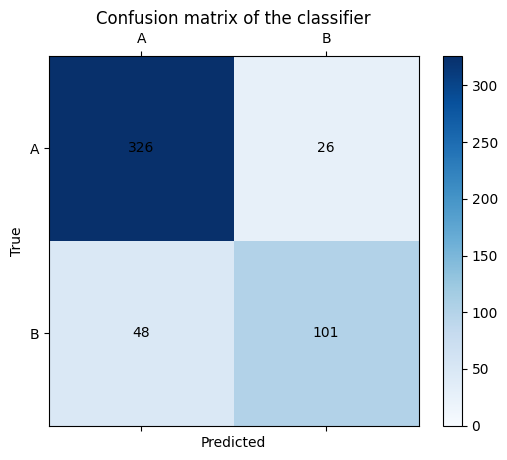

In [215]:
# Display confusion matrix
plt.show()

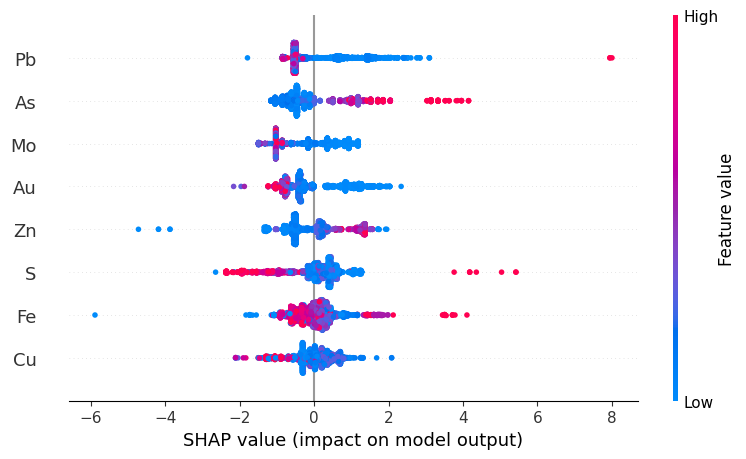

In [216]:
# Use SHAP to explain the model
xg_explainer = shap.TreeExplainer(gb_clf2)
shap_values = xg_explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, class_names=targets)

In [217]:
# Isolate the numeric ME data and store in a NumPy array
data_ME = data.iloc[:, 4:12].to_numpy()

In [218]:
# Perform an centered log ratio transformation on the ME data and store the data in a Pandas DataFrame
data_clr = pd.DataFrame(clr(data_ME))

In [219]:
# Perform a dimensionality reduction of the ME data using Unifold Manifold Approximation & Projection (UMAP)
reducer = UMAP(n_neighbors=100,
               n_components=2,
               metric='euclidean',
               n_epochs=1000,
               learning_rate=1.0,
               init='spectral',
               min_dist=0.1,
               spread=1.0,
               low_memory=False,
               set_op_mix_ratio=1.0,
               local_connectivity=1,
               repulsion_strength=1.0,
               negative_sample_rate=5,
               transform_queue_size=4.0,
               a=None,
               b=None,
               random_state=42,
               metric_kwds=None,
               angular_rp_forest=False,
               target_n_neighbors=-1,
               transform_seed=42,
               verbose=False,
               unique=False
               )

# Fit and transform the data
UMAP = reducer.fit_transform(data_clr)

In [220]:
class SelectFromCollection:
    # Code for class taken from: https://matplotlib.org/stable/gallery/widgets/polygon_selector_demo.html

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.poly = PolygonSelector(ax, self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.poly.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

In [221]:
def plot_points(UMAP_x, UMAP_y, colors, categories):
    fig = plt.figure()

    # Plot the scatter plot with labels and title
    ax = fig.gca()
    pts = ax.scatter(UMAP_x, UMAP_y, c=colors, s=8)
    plt.gca().set(xlabel='x', ylabel='y', title='UMAP applied to the Broken Down lead deposit, Tasmania')

    # Shrink current axis by 20% so that legend can fit outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Set the colours for each Class
    handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c) for i, c in enumerate(categories)]

    # Reorder legend in alphabetical order
    sorted_list = sorted(categories)
    order = []
    for item in sorted_list:
        index = list(categories).index(item)
        order.append(index)
    handles = [handles[i] for i in order]

    # Add legend and display plot
    plt.legend(handles=handles, title='Class', bbox_to_anchor=(1.05, 1.0), loc='upper left',
               borderaxespad=0.)

    # Enable the option of selecting points on the screen
    # selector = SelectFromCollection(ax, pts)

    plt.show()
    plt.close(fig)

    return # selector

In [222]:
# Separate UMAP array into two columns - x and y axis - for scatter plot
UMAP_x, UMAP_y = pd.DataFrame(UMAP[:, 0]), pd.DataFrame(UMAP[:, 1])

In [223]:
# Get list of unique classes
classes = data['Class']
levels, categories = pd.factorize(classes)
colors = [plt.cm.tab20(i) for i in levels]

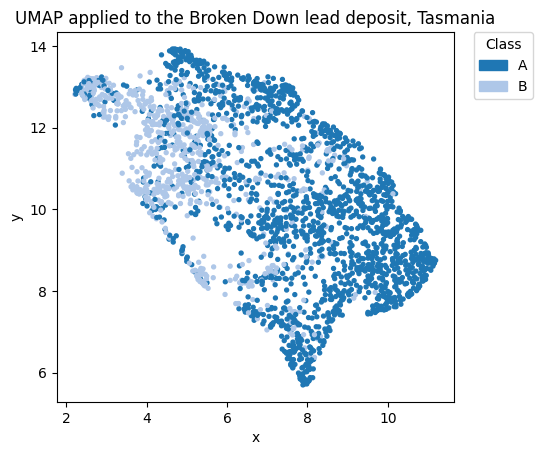

In [224]:
# Display the first plot
selector = plot_points(UMAP_x, UMAP_y, colors, categories)